In [1]:
import base64
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter, Gate
from typing import List
from gymnasium.spaces import Box
from rl_qoc.qua import QMEnvironment, QMConfig
from rl_qoc.qua.iqcc import *
from iqcc_calibration_tools.quam_config.components import Quam, Transmon
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    QMInstructionProperties,
    InputType,
    ParameterPool,
)
from qiskit_qm_provider.backend.backend_utils import add_basic_macros_to_machine
from rl_qoc.agent.ppo_config import (
    TotalUpdates,
    TrainingConfig,
)
from rl_qoc import (
    RescaleAndClipAction,
    ChannelReward,
    StateReward,
    CAFEReward,
    ExecutionConfig,
    QEnvConfig,
    BenchmarkConfig,
    StateTarget,
    GateTarget,
    PPOConfig,
)
from rl_qoc.helpers import add_custom_gate
from rl_qoc.helpers import load_from_yaml_file

import json
import os
import sys
from pathlib import Path

from rl_qoc.qua.pi_pulse_reward.pi_pulse_reward import PiPulseReward
from rl_qoc.qua.qua_ppo import CustomQMPPO

# Set your quantum computer backend
path = Path.home() / "iqcc_token.json"
with open(path, "r") as f:
    iqcc_config = json.load(f)

backend_name = "gilboa"
machine, iqcc = get_machine_from_iqcc(backend_name, iqcc_config[backend_name])

add_basic_macros_to_machine(machine)
backend = FluxTunableTransmonBackend(machine)
print(backend.target)


/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")


2025-08-20 11:26:03,391 - qm - INFO     - Starting session: 95a91e24-49af-4f65-a836-10a4e34a8ccb
2025-08-20 11:26:03 INFO Starting session: 95a91e24-49af-4f65-a836-10a4e34a8ccb
Target: Qiskit Backend for Quantum Abstract Machine (Quam)
Number of qubits: 2
Instructions:
	x
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	rz
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	sx
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	delay
		(0,):
		(1,):
	reset
		(0,):
			Duration: 5.5292e-05 sec.
		(1,):
			Duration: 0.000131964 sec.
	measure
		(0,):
			Duration: 1.65e-06 sec.
		(1,):
			Duration: 1.65e-06 sec.
	sy
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	sydg
		(0,):
			Duration: 3.2e-08 sec.
		(1,):
			Duration: 3.2e-08 sec.
	id
		(0,):
			Duration: 0 sec.
			Error Rate: 0
		(1,):
			Duration: 0 sec.
			Error Rate: 0
	cz
		(1, 0)
	if_else
	while_loop
	for_loop
	switch_case
	box



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/backend_utils.py:215: UserWarning: Could not add default two qubit gates. Add it manually if necessary.
  warnings.warn("Could not add default two qubit gates. Add it manually if necessary.")
/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:52: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [2]:
path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/x_cal"
agent_config_path = os.path.join(path, "agent_config.yaml")
ppo_config = load_from_yaml_file(agent_config_path)


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: List[Parameter], q_reg: QuantumRegister, **kwargs
):

    physical_qubits: List[int] = kwargs["physical_qubits"]
    backend: FluxTunableTransmonBackend = kwargs["backend"]

    # TODO: Enter your custom parametric QUA macro here
    def qua_macro(amp):
        qubit: Transmon = backend.get_qubit(physical_qubits[0])
        qubit.xy.play("x180", amplitude_scale=amp)

    # Create a custom gate with the QUA macro
    custom_x = Gate("x_cal", 1, params)
    instruction_prop = QMInstructionProperties(qua_pulse_macro=qua_macro)
    qc = add_custom_gate(qc, custom_x, q_reg, params, physical_qubits, backend, instruction_prop)
    return qc


physical_qubits = (0,)

target_name = "rx"
target = GateTarget(gate=target_name, physical_qubits=physical_qubits)
reward =  ChannelReward()

# target_name = "1"
# target = StateTarget(state=target_name, physical_qubits=physical_qubits)
# reward =  PiPulseReward()


# Action space specification
param_bounds = [(-1.98, 2.0)]  # Can be any number of bounds

# Environment execution parameters
seed = 1203  # Master seed to make training reproducible
batch_size = 32  # Number of actions to evaluate per policy evaluation
n_shots = 50  # Minimum number of shots per fiducial evaluation
pauli_sampling = 100  # Number of fiducials to compute for fidelity estimation (DFE only)
n_reps = 1  # Number of repetitions of the cycle circuit
num_updates = TotalUpdates(50)
input_type = InputType.INPUT_STREAM


def create_action_space(param_bounds):
    param_bounds = np.array(param_bounds, dtype=np.float32)
    lower_bound, upper_bound = param_bounds.T
    return Box(low=lower_bound, high=upper_bound, shape=(len(param_bounds),), dtype=np.float32)


action_space = create_action_space(param_bounds)

backend_config = QMConfig(
    parametrized_circuit=apply_parametrized_circuit,
    backend=backend,
    input_type=input_type,
    verbosity=2,
    parametrized_circuit_kwargs={"physical_qubits": physical_qubits, "backend": backend},
    num_updates=num_updates.total_updates,
)
execution_config = ExecutionConfig(
    batch_size=batch_size,
    sampling_paulis=pauli_sampling,
    n_shots=n_shots,
    n_reps=n_reps,
    seed=seed,
)
q_env_config = QEnvConfig(
    target=target,
    backend_config=backend_config,
    action_space=action_space,
    execution_config=execution_config,
    reward=reward,
    benchmark_config=BenchmarkConfig(0),
)  # No benchmark for now

q_env = QMEnvironment(training_config=q_env_config)
rescaled_env = RescaleAndClipAction(q_env, -1.0, 1.0)



/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [24]:
sync_hook_path = generate_sync_hook(
    target=target,
    reward=reward,
    param_bounds=param_bounds,
    seed=seed,
    batch_size=batch_size,
    n_shots=n_shots,
    pauli_sampling=pauli_sampling,
    n_reps=n_reps,
    num_updates=num_updates,
    input_type=input_type,
    backend_config=backend_config,
    ppo_config=ppo_config,
    output_dir=path
    
)
print(f"Sync hook file generated at: {sync_hook_path}")


Sync hook file generated at: /Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/sync_hook_iqcc/x_cal/sync_hook.py


In [3]:
q_env.circuit_params

CircuitParams(input_state_vars=ParameterTable(input_state_vars: {Parameter(input_state_0[int]))}, observable_vars=ParameterTable(observable_vars: {Parameter(observable_0[int]))}, n_reps_var=None, circuit_choice_var=None, n_shots=Parameter(pauli_shots[int]), max_input_state=Parameter(max_input_state[int]), max_observables=Parameter(max_observables[int]), real_time_circuit_parameters=ParameterTable(real_time_circuit_parameters: {Parameter(a_0_0[fixed]))}, context_parameters=None)

In [8]:
list(q_env.target.context_parameters.keys())

[Parameter(ϴ)]

In [5]:

if hasattr(q_env.real_time_circuit, "calibrations") and q_env.real_time_circuit.calibrations:
    backend.update_calibrations(qc=q_env.real_time_circuit, input_type=input_type)
backend.update_compiler_from_target()
prog = q_env.rl_qoc_training_qua_prog(num_updates=num_updates.total_updates)

In [6]:
run_data = iqcc.execute(
    prog,
    backend.qm_config,
    terminal_output=True,
    options={"sync_hook": sync_hook_path, "timeout": 600, "profiling": False},
)

/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/quam/quam/components/channels.py:636: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(


Output()

[10:08:09] QUA program submitted to gilboa (id = 1dd3fdc4-0fd7-4467-9e2b-93df8f24c8a7)             ]8;id=229009;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=88687;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#426\426]8;;\

[10:08:10] Execution started                                                                       ]8;id=555302;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=674919;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#446\446]8;;\

[10:08:50] Execution finished                                                                      ]8;id=81877;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=993128;file:///Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/.venv/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#460\460]8;;\

QUA program has error:

/app/temp.py:8286: UserWarning: name 'result_handles' is not defined
  warnings.warn(str(e))
/app/temp.py:8291: UserWarning: name 'end_time' is not defined
  warnings.warn(str(e))

 👍     stdout:

 🚨     stderr:

/app/temp.py:8286: UserWarning: name 'result_handles' is not defined
  warnings.warn(str(e))
/app/temp.py:8291: UserWarning: name 'end_time' is not defined
  warnings.warn(str(e))

 ⚛️      result

{}

 🚀     sync-hook stdout:

Pushing value [-0.1190081536769867] to mu through input stream.
Pushing value [0.4883597493171692] to sigma through input stream.
Just pushed policy parameters to OPX: [-0.1190081536769867] [0.4883597493171692]
Rescaled mean: [-0.22682629]
Fetching index: 0, finishing index: 1
Fetching size: 1
Step indices: {1: (0, 1)}
Total data points: 1
Fetching value from reward with input type None
Fetched value: [[[20 30]
  [49  1]
  [49  1]
  [14 36]
  [ 6 44]
  [47  3]
  [47  3]
  [49  1]
  [ 4 46]
  [46  4]
  [ 7 43]
  [42  8]
  [24 26]
  [ 3 47]
  [ 4 46]
  [36 14]
  [21 29]
  [22 28]
  [43  7]
  [18 32]
  [32 18]
  [21 29]
  [ 8 42]
  [25 25]
  [30 20]
  [48  2]
  [ 9 41]
  [41  9]
  [25 25]
  [45  5]
  [42  8]
  [ 7 43]]]
mean [-0.11900815]
sigma [0.48835975]
DFE Rewards Mean: 0.4475
DFE Rewards standard dev 0.3231775827621712
Returns Mean: 0.4475
Returns standard dev: 0.32317758
Advantages Mean: 0.38896072
Advantages standard dev 0.32317758
Pushing value [-0.10748735070228577] to mu through input stream.
Pushing value [0.49516528844833374] to sigma through input stream.
Just pushed policy parameters to OPX: [-0.10748735070228577] [0.49516528844833374]
Rescaled mean: [-0.2038999]
Fetching index: 1, finishing index: 2
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2)}
Total data points: 2
Fetching value from reward with input type None
Fetched value: [[[47  3]
  [ 5 45]
  [ 4 46]
  [17 33]
  [12 38]
  [12 38]
  [48  2]
  [27 23]
  [40 10]
  [40 10]
  [30 20]
  [ 5 45]
  [44  6]
  [17 33]
  [ 2 48]
  [ 7 43]
  [43  7]
  [ 4 46]
  [49  1]
  [40 10]
  [33 17]
  [34 16]
  [17 33]
  [49  1]
  [23 27]
  [11 39]
  [46  4]
  [43  7]
  [39 11]
  [49  1]
  [ 9 41]
  [40 10]]]
mean [-0.10748735]
sigma [0.4951653]
DFE Rewards Mean: 0.44625000000000004
DFE Rewards standard dev 0.33073544941539
Returns Mean: 0.44625002
Returns standard dev: 0.33073545
Advantages Mean: 0.34545398
Advantages standard dev 0.33073545
Pushing value [-0.08570842444896698] to mu through input stream.
Pushing value [0.5092138648033142] to sigma through input stream.
Just pushed policy parameters to OPX: [-0.08570842444896698] [0.5092138648033142]
Rescaled mean: [-0.16055983]
Fetching index: 2, finishing index: 3
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3)}
Total data points: 3
Fetching value from reward with input type None
Fetched value: [[[19 31]
  [ 6 44]
  [22 28]
  [46  4]
  [41  9]
  [10 40]
  [47  3]
  [18 32]
  [25 25]
  [22 28]
  [43  7]
  [14 36]
  [48  2]
  [ 8 42]
  [ 9 41]
  [43  7]
  [48  2]
  [48  2]
  [15 35]
  [ 4 46]
  [ 3 47]
  [ 1 49]
  [35 15]
  [29 21]
  [38 12]
  [33 17]
  [45  5]
  [42  8]
  [49  1]
  [34 16]
  [10 40]
  [ 5 45]]]
mean [-0.08570842]
sigma [0.50921386]
DFE Rewards Mean: 0.46249999999999997
DFE Rewards standard dev 0.3274809154744746
Returns Mean: 0.4625
Returns standard dev: 0.3274809
Advantages Mean: 0.29815644
Advantages standard dev 0.3274809
Pushing value [-0.04549979791045189] to mu through input stream.
Pushing value [0.5166299939155579] to sigma through input stream.
Just pushed policy parameters to OPX: [-0.04549979791045189] [0.5166299939155579]
Rescaled mean: [-0.08054467]
Fetching index: 3, finishing index: 4
Fetching size: 1
Step indices: {1: (0, 1), 2: (1, 2), 3: (2, 3), 4: (3, 4)}
Total data points: 4
Fetching value from reward with input type None
Fetched value: [[[13 37]
  [49  1]
  [38 12]
  [47  3]
  [35 15]
  [20 30]
  [49  1]
  [49  1]
  [42  8]
  [44  6]
  [22 28]
  [ 9 41]
  [48  2]
  [ 3 47]
  [49  1]
  [42  8]
  [49  1]
  [ 5 45]
  [10 40]
  [32 18]
  [46  4]
  [48  2]
  [25 25]
  [ 6 44]
  [11 39]
  [ 7 43]
  [ 4 46]
  [ 9 41]
  [27 23]
  [43  7]
  [31 19]
  [28 22]]]
mean [-0.0454998]
sigma [0.51663]
DFE Rewards Mean: 0.4125
DFE Rewards standard dev 0.3354381463101655
Returns Mean: 0.41250002
Returns standard dev: 0.33543813
Advantages Mean: 0.1607545
Advantages standard dev 0.33543813
Pushing value [0.02821674570441246] to mu through input stream.
Pushing value [0.5164170265197754] 

 🚀     sync-hook stderr:

/app/.venv/lib/python3.11/site-packages/rl_qoc/helpers/__init__.py:9: UserWarning: pulse_utils is not available
  warnings.warn("pulse_utils is not available")
/app/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: [33mWARN: Box low's precision 
lowered by casting to float32, current low.dtype=float64[0m
  gym.logger.warn(
/app/.venv/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: [33mWARN: Box high's precision 
lowered by casting to float32, current high.dtype=float64[0m
  gym.logger.warn(
wandb: No netrc file found, creating one.
wandb: WARNING Unable to write /home/worker/.netrc
wandb: Currently logged in as: arthurostrauss (quantumcontrolwithrl) to https://api.wandb.ai. Use `wandb login 
--relogin` to force relogin
2025/08/20 02:08:20 ERROR main: failed to get logger path error="error creating log directory: mkdir 
/home/worker/.cache: permission denied"
2025/08/20 02:08:20 INFO server: will exit if parent process dies ppid=41817
2025/08/20 02:08:20 INFO server: accepting connections addr=/tmp/wandb-41817-42032-3388452994/socket
2025/08/20 02:08:21 INFO connection: ManageConnectionData: new connection created id=1(@)
2025/08/20 02:08:21 INFO handleInformInit: received streamId=fw85rrp2 id=1(@)
2025/08/20 02:08:21 INFO handleInformInit: stream started streamId=fw85rrp2 id=1(@)
wandb: Tracking run with wandb version 0.21.1
wandb: Run data is saved locally in /app/wandb/run-20250820_020820-fw85rrp2
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run test_pi_pulse
wandb: ⭐️ View project at https://wandb.ai/quantumcontrolwithrl/IQCC-Cloud
wandb: 🚀 View run at https://wandb.ai/quantumcontrolwithrl/IQCC-Cloud/runs/fw85rrp2
2025/08/20 02:08:46 INFO handleInformTeardown: server teardown initiated id=1(@)
2025/08/20 02:08:46 INFO connection: closing id=1(@)
2025/08/20 02:08:46 INFO server is shutting down
2025/08/20 02:08:46 INFO connection: closed successfully id=1(@)
2025/08/20 02:08:46 INFO server: listener closed addr=/tmp/wandb-41817-42032-3388452994/socket
2025/08/20 02:08:48 INFO handleInformTeardown: server shutdown complete id=1(@)
2025/08/20 02:08:48 INFO connection: ManageConnectionData: connection closed id=1(@)
2025/08/20 02:08:48 INFO server is closed

 🕗 🐍  total Python execution time (s)

40.120

 🕗 ⚛️   QUA execution time (s)

0.000

In [7]:
run_data

{'result': {'__sync_hook': {'stdout': 'Pushing value [-0.1190081536769867] to mu through input stream.\nPushing value [0.4883597493171692] to sigma through input stream.\nJust pushed policy parameters to OPX: [-0.1190081536769867] [0.4883597493171692]\nRescaled mean: [-0.22682629]\nFetching index: 0, finishing index: 1\nFetching size: 1\nStep indices: {1: (0, 1)}\nTotal data points: 1\nFetching value from reward with input type None\nFetched value: [[[20 30]\n  [49  1]\n  [49  1]\n  [14 36]\n  [ 6 44]\n  [47  3]\n  [47  3]\n  [49  1]\n  [ 4 46]\n  [46  4]\n  [ 7 43]\n  [42  8]\n  [24 26]\n  [ 3 47]\n  [ 4 46]\n  [36 14]\n  [21 29]\n  [22 28]\n  [43  7]\n  [18 32]\n  [32 18]\n  [21 29]\n  [ 8 42]\n  [25 25]\n  [30 20]\n  [48  2]\n  [ 9 41]\n  [41  9]\n  [25 25]\n  [45  5]\n  [42  8]\n  [ 7 43]]]\nmean [-0.11900815]\nsigma [0.48835975]\nDFE Rewards Mean: 0.4475\nDFE Rewards standard dev 0.3231775827621712\nReturns Mean: 0.4475\nReturns standard dev: 0.32317758\nAdvantages Mean: 0.3889607

In [11]:
import wandb
api = wandb.Api()

run = api.run("quantumcontrolwithrl/IQCC-Cloud/fw85rrp2")
if run.state == "finished":
    for i, row in run.history().iterrows():
      print(row["_timestamp"], row["avg_reward"])

1755655702.2248616 0.4475
1755655702.656598 0.44625000000000004
1755655703.194108 0.46249999999999997
1755655703.7305076 0.4125
1755655704.1612332 0.5175
1755655704.6745217 0.40875
1755655705.1891265 0.485625
1755655705.7311711 0.621875
1755655706.1606874 0.40249999999999997
1755655706.7269323 0.4275
1755655707.1479049 0.5425
1755655707.6756468 0.4075
1755655708.210833 0.435
1755655708.7451596 0.56125
1755655709.1704473 0.425
1755655709.7059703 0.409375
1755655710.2403643 0.506875
1755655710.6644375 0.454375
1755655711.1968932 0.40625
1755655711.7687929 0.500625
1755655712.2014923 0.451875
1755655712.7162993 0.43562499999999993
1755655713.2314267 0.4875
1755655713.6821973 0.50125
1755655714.1947224 0.4575
1755655714.7067564 0.37
1755655715.2454257 0.513125
1755655715.6504083 0.450625
1755655716.1661592 0.546875
1755655716.7143862 0.440625
1755655717.2521012 0.33875
1755655717.6771553 0.38375
1755655718.2067568 0.49624999999999997
1755655718.7409868 0.379375
1755655719.1637099 0.475
175

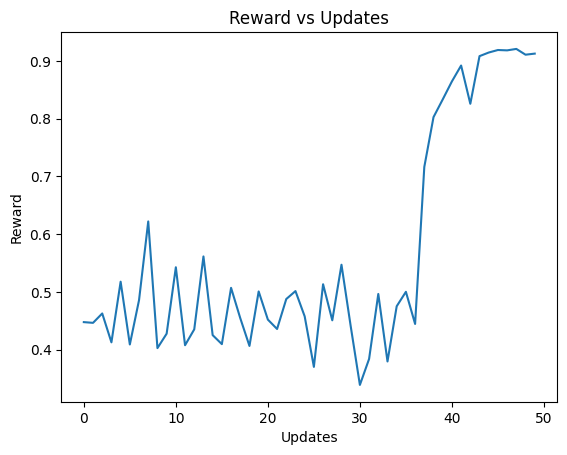

In [21]:
import matplotlib.pyplot as plt
plt.plot(run.history()["avg_reward"])
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title("Reward vs Updates")
plt.show()